In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

url = 'https://raw.githubusercontent.com/akay6483/mmml-ecommerce/refs/heads/main/dataset/online_shoppers_intention.csv'
df = pd.read_csv(url).drop_duplicates()

X = df.drop('Revenue', axis=1)
y = df['Revenue']

for col in X.select_dtypes(include=['object', 'bool']).columns:
    X[col] = pd.factorize(X[col])[0]
y = LabelEncoder().fit_transform(y)

X_scaled = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

print(f"Data Processed. Features: {X.shape[1]}, Samples: {X.shape[0]}")

Data Processed. Features: 17, Samples: 12205


PCA
Number of components for 95% variance: 14


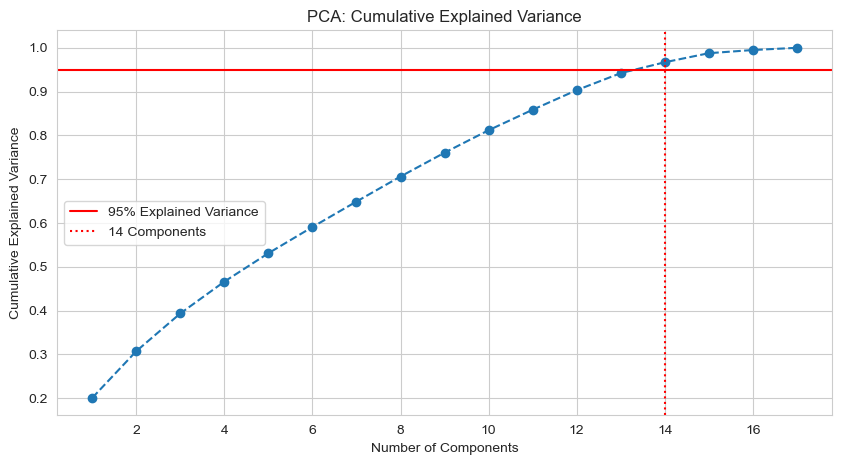

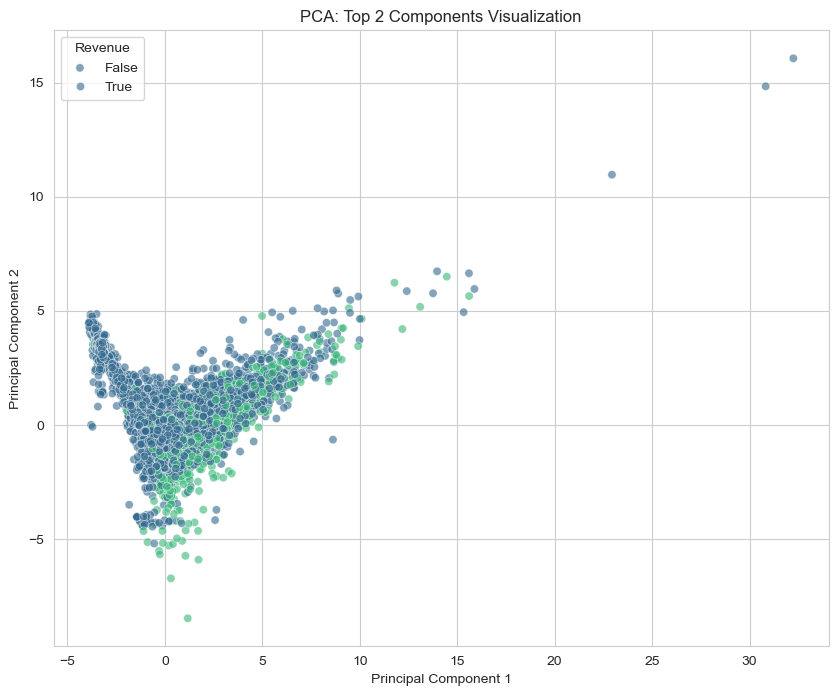

In [6]:
print("PCA")

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

print(f"Number of components for 95% variance: {n_components_95}")

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='-', label='95% Explained Variance')
plt.axvline(x=n_components_95, color='r', linestyle=':', label=f'{n_components_95} Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Cumulative Explained Variance')
plt.legend()
plt.grid(True)
plt.show()

pca_2 = PCA(n_components=2)
X_pca_2 = pca_2.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca_2[:, 0], y=X_pca_2[:, 1], hue=y, palette='viridis', alpha=0.6)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: Top 2 Components Visualization')
plt.legend(title='Revenue', labels=['False', 'True'])
plt.show()

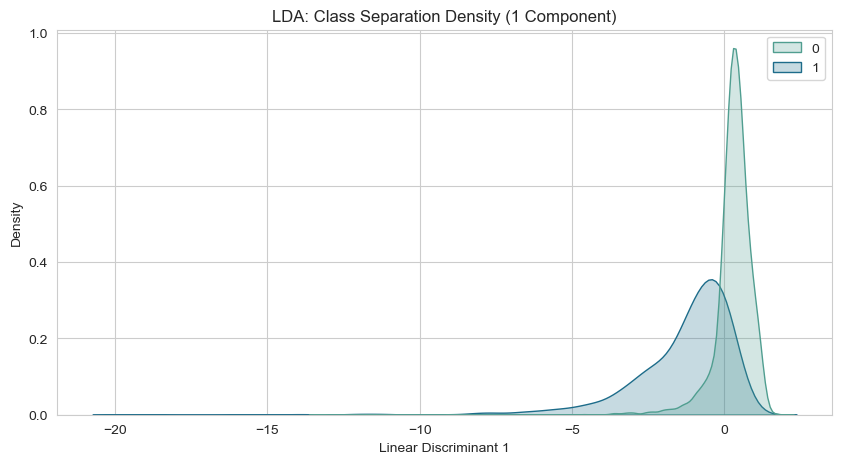

Running Feature Selection...

=== Final Results ===
LDA Accuracy:                         0.8820
Logistic Regression (All 17 Features): 0.8880
Logistic Regression (Top 5 Features):  0.8872
Top 5 Features Selected: ['ExitRates', 'PageValues', 'Browser', 'VisitorType', 'Weekend']


In [7]:
lda = LDA(n_components=1)
X_lda = lda.fit_transform(X_train, y_train)
y_pred_lda = lda.predict(X_test)

plt.figure(figsize=(10, 5))
sns.kdeplot(x=X_lda.flatten(), hue=y_train, fill=True, palette='crest', common_norm=False)
plt.title('LDA: Class Separation Density (1 Component)')
plt.xlabel('Linear Discriminant 1')
plt.show()

print("Running Feature Selection...")
clf = LogisticRegression(max_iter=1000, random_state=42)
sfs = SequentialFeatureSelector(clf, n_features_to_select=5, direction='forward')
sfs.fit(X_train, y_train)

selected_feats = X.columns[sfs.get_support()].tolist()

clf.fit(sfs.transform(X_train), y_train)
acc_sfs = accuracy_score(y_test, clf.predict(sfs.transform(X_test)))

clf.fit(X_train, y_train)
acc_all = accuracy_score(y_test, clf.predict(X_test))

print("\n=== Final Results ===")
print(f"LDA Accuracy:                         {accuracy_score(y_test, y_pred_lda):.4f}")
print(f"Logistic Regression (All 17 Features): {acc_all:.4f}")
print(f"Logistic Regression (Top 5 Features):  {acc_sfs:.4f}")
print(f"Top 5 Features Selected: {selected_feats}")

In [8]:
print("Running Sequential Feature Selection (this may take a moment)...")

model_lr = LogisticRegression(max_iter=1000, random_state=42)

sfs = SequentialFeatureSelector(model_lr, n_features_to_select=5, direction='forward')
sfs.fit(X_train, y_train)

selected_indices = sfs.get_support(indices=True)
selected_features = X.columns[selected_indices].tolist()
print(f"Top 5 Selected Features: {selected_features}")

X_train_sfs = sfs.transform(X_train)
X_test_sfs = sfs.transform(X_test)
model_lr.fit(X_train_sfs, y_train)
acc_sfs = accuracy_score(y_test, model_lr.predict(X_test_sfs))

model_lr.fit(X_train, y_train)
acc_all = accuracy_score(y_test, model_lr.predict(X_test))

print(f"Accuracy (All 17 Features): {acc_all:.4f}")
print(f"Accuracy (Top 5 Features): {acc_sfs:.4f}")

Running Sequential Feature Selection (this may take a moment)...
Top 5 Selected Features: ['ExitRates', 'PageValues', 'Browser', 'VisitorType', 'Weekend']
Accuracy (All 17 Features): 0.8880
Accuracy (Top 5 Features): 0.8872


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import classification_report, confusion_matrix

pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2],
                c=y, cmap='viridis', s=20, alpha=0.6)

ax.set_title('3D PCA Visualization')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.colorbar(sc, label='Revenue (True/False)')
plt.show()

plt.figure(figsize=(12, 6))
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'][:pca.n_components_], index=X.columns)
sns.heatmap(loadings.iloc[:, :2], annot=True, cmap='coolwarm', fmt=".2f")
plt.title('PCA Loadings: Feature Correlation with PC1 & PC2')
plt.show()


y_pred = model_lr.predict(X_test)

print("Classification Report (Better than Accuracy):")
print(classification_report(y_test, y_pred, target_names=['No Revenue', 'Revenue']))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted No', 'Predicted Yes'],
            yticklabels=['Actual No', 'Actual Yes'])
plt.title('Confusion Matrix')
plt.show()